<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/Visualizing_the_Solution_Path_on_2d_Synthetic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!wget -O helpers.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py

import helpers

--2023-11-21 00:04:08--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/my_logit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5862 (5.7K) [text/plain]
Saving to: ‘my_logit.py’

my_logit.py         100%[===================>]   5.72K  --.-KB/s    in 0s      

2023-11-21 00:04:08 (78.3 MB/s) - ‘my_logit.py’ saved [5862/5862]



In [ ]:
!wget -O SGD.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py

import SGD

--2023-11-21 00:04:08--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4938 (4.8K) [text/plain]
Saving to: ‘SGD.py’

SGD.py              100%[===================>]   4.82K  --.-KB/s    in 0s      

2023-11-21 00:04:08 (69.0 MB/s) - ‘SGD.py’ saved [4938/4938]



# Helper Functions (debugging)

In [ ]:
import random
import math
from scipy.special import legendre

In [ ]:
# compute \Phi(\lambda)
def phi_lam_Legendre(lam, basis_dim):
    # Transform the lam to [-1, 1] interval
    lam_transformed = 2 * lam - 1
    vec = torch.zeros(basis_dim)
    for i in range(basis_dim):
        vec[i] = math.sqrt(2*i+1) * legendre(i)(lam_transformed)
    return vec.to(device)

In [ ]:
# this initializes with random weights. Need to either set a seed or force initialization somewhere for reproducibility.
# automatically fits an intercept. To turn off intercept, set bias=False in nn.Linear()
class Basis_TF_SGD(nn.Module):
    def __init__(self, feature_dim, basis_dim, basis_fn, init_weight=None, intercept=True):
        super(Basis_TF_SGD, self).__init__()
        self.feature_dim = feature_dim
        self.basis_dim = basis_dim
        self.linear = nn.Linear(self.basis_dim, self.feature_dim + 1, bias=False)
        self.basis_fn = basis_fn
        self.intercept = intercept

        # initialize for better performance
        with torch.no_grad():
          if init_weight is not None:
              self.linear.weight.copy_(init_weight)
          else:
              self.linear.weight.data.fill_(0)

    # model takes input lambda and outputs theta
    def forward(self, lam):
        phi = self.basis_fn(lam, self.basis_dim)
        return self.linear(phi)

In [ ]:
# trace_frequency is measured in number of batches. -1 means don't print
def train_SGD(dataloader, model, loss_fn, optimizer, distribution='uniform', trace_frequency=-1):
    model.train()
    actv = nn.Sigmoid()
    for batch, (X_train, y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        rndm_lam = torch.tensor(0.5)
        # SGD picks random regulation parameter lambda
        if distribution == 'uniform':
            rndm_lam = torch.torch.distributions.Uniform(0, 1).sample()
        # print(f"random lam = {rndm_lam}")

        # Compute predicted y_hat
        theta = model(rndm_lam.cpu())
        pred = torch.mm(X_train, theta[1:].view(-1, 1))
        if model.intercept:
            const = torch.ones(len(X_train), 1).to(device)
            pred += torch.mm(const, theta[0].view(-1, 1))
        pred = actv(pred)
        # print(theta[0])

        loss = (1 - rndm_lam) * loss_fn(pred.view(-1, 1), y_train.view(-1, 1))
        loss += rndm_lam * 0.5 * theta.norm(p=2)**2

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (trace_frequency > 0) & (batch % trace_frequency == 0):
        #     loss, current = loss.item(), (batch + 1) * len(X_train)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Test function
def test_SGD(dataloader, model, loss_fn, lam):
    model.eval() #important
    actv = nn.Sigmoid()
    with torch.no_grad():  #makes sure we don't corrupt gradients and is faster
        for batch, (X_test, y_test) in enumerate(dataloader):
          X_test, y_test = X_test.to(device), y_test.to(device)

          # Compute prediction error
          theta = model(lam)
          pred = actv(torch.mm(X_test, theta[1:].view(-1, 1)) + theta[0].item())
          # print(f"prediction = {pred}")

          oos = (1 - lam) * loss_fn(pred.view(-1, 1), y_test.view(-1, 1))
          oos += lam * 0.5 * theta.norm(p=2)**2

    return oos.item()

In [ ]:
def get_sup_error_SGD(lam_min, lam_max, true_loss_list, model, data_loader, criterion):
    fine_delta_lam = (lam_max - lam_min)/len(true_loss_list)
    # check sup error
    sup_error = 0
    for i in range(len(true_loss_list)):
        exact_soln = true_loss_list[i]
        temp = 1 - i * fine_delta_lam
        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_soln = my_module.test_SGD(data_loader, model, criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        # print(sup_error)
    return sup_error.item()

In [ ]:
def get_losses_SGD(model, lam_min, lam_max, num_grid, data_loader, criterion):
    delta_lam = (lam_max - lam_min)/num_grid
    lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam)
    losses = []
    for lam in lambdas:
        losses.append(my_module.test_SGD(data_loader, model, criterion, lam))

    return losses

# Visualizing the Solution Path

## Generate the true solution path with 2d synthetic data

In [ ]:
#some synthetic data for instance below
np.random.seed(8675309)
torch.manual_seed(8675309) #Ensures linear layer initializes deterministically for reproducibility

X_syn, y_syn = helpers.gen_data(100, 100, 2)

In [ ]:
#The pytorch built-in binary cross-entropy loss
criterion = torch.nn.BCELoss()
input_dim_syn = X_syn.shape[1]

In [ ]:
syn_data = helpers.Regression_Data(X_syn, y_syn)
syn_data_loader = helpers.DataLoader(syn_data, batch_size=len(syn_data), shuffle=False, )

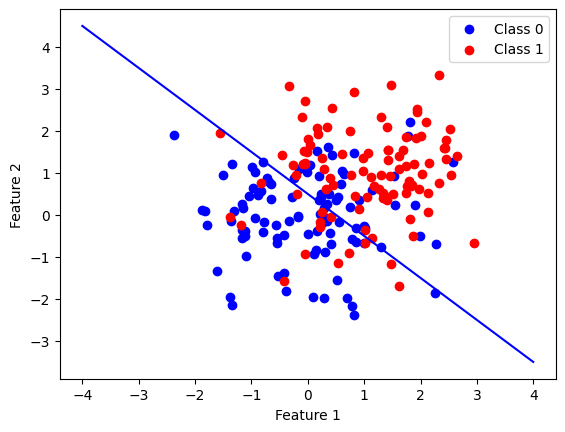

In [ ]:
# Separate data points by class
class_0 = X_syn[y_syn == 0]
class_1 = X_syn[y_syn == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], c='b', marker='o', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], c='r', marker='o', label='Class 1')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')

# plot perfect separator
x_1 = np.linspace(-4, 4, 100)
x_2 = -x_1 + .5
plt.plot(x_1, x_2, color='blue')

# Show the plot
plt.show()

Create the exact solution path with naive grid search on $2^{10}$ grid points.

In [ ]:
lam_max = 1
lam_min = 0
num_grid = 2**10
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam)

In [ ]:
# epochs = 5000
# lr = 0.5**4

In [ ]:
# models, num_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
#                                     num_grid=num_grid, epochs=epochs,
#                                     trainDataLoader=syn_data_loader,
#                                     data_input_dim=input_dim_syn,
#                                     lr=lr, SGD=False)

In [ ]:
# thetas = []
# for model in models:
#     thetas.append(model.linear.weight.data.detach().numpy()[0])
# thetas = np.array(thetas)
# print(thetas.shape)

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/syn_exact_soln_list.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['feature 1', 'feature 2'])

#     # Write the data from your lists
#     for i in range(len(thetas)):
#         csv_writer.writerow([thetas[i,0], thetas[i,1]])

In [ ]:
import pandas as pd
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/syn_exact_soln_list.csv'
thetas = pd.read_csv(csv_file_path)
thetas = np.array(thetas)

Text(0, 0.5, 'Feature 2')

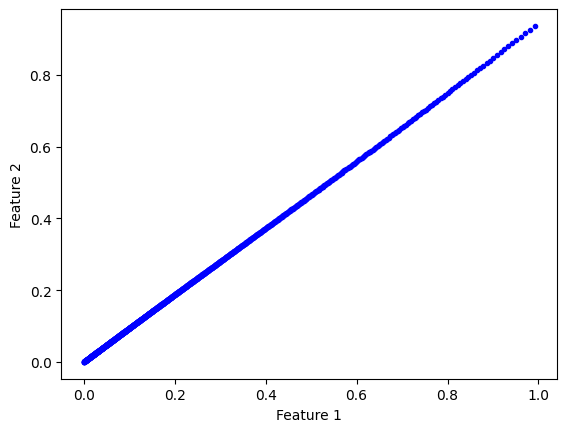

In [ ]:
# Create a scatter plot
plt.scatter(thetas[:, 0], thetas[:, 1], c='b', marker='.', label='exact solution path')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

## Test our algorithm and compare to the true solution path

We use Legendre polynomials as the basis vectors for $\Phi(\lambda)$.

In [ ]:
phi_lam = SGD.phi_lam_Legendre

In [ ]:
phi_lam(1, 11)

tensor([1.0000, 1.7321, 2.2361, 2.6458, 3.0000, 3.3166, 3.6056, 3.8730, 4.1231,
        4.3589, 4.5826])

In [ ]:
# build the model
basis_dim = 10
epoch = 500
lr = 0.5**4

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    SGD.train_SGD(syn_data_loader, model, criterion, optimizer)
    if (t+1) % 100 == 0:
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [ ]:
true_loss_list = SGD.get_losses_SGD(model=model, lam_min=0, lam_max=1, num_grid=2**10,
                                data_loader=syn_data_loader, criterion=criterion)

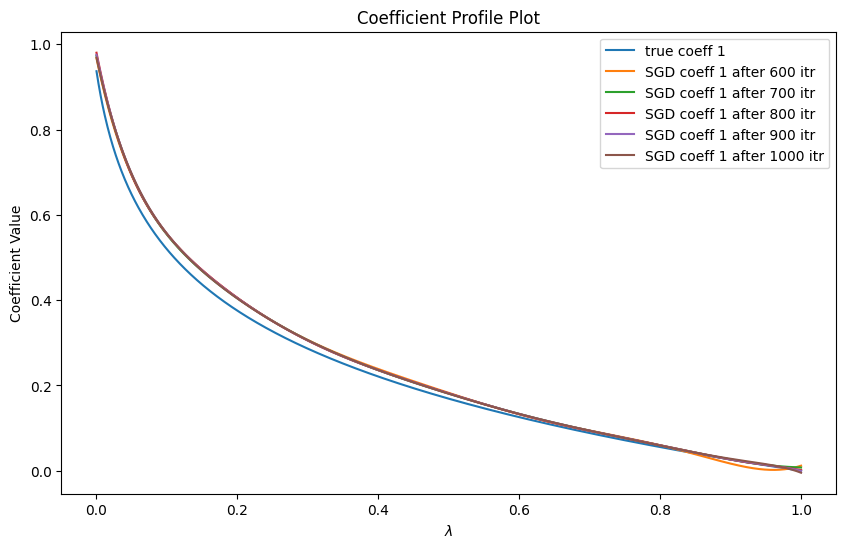

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, thetas[:,1], label=f'true coeff {1}')

for i in range(5, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,1], label=f'SGD coeff {1} after {(i+1)*100} itr')


# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Profile Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# build the model
basis_dim = 11
epoch = 1000
lr = 0.5**5

np.random.seed(8675309)
torch.manual_seed(8675309)
new_model = SGD.Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(new_model.parameters(), lr=lr)
optimizer.zero_grad()
new_thetas_SGD_history = []
sup_error_list = []
for t in range(epoch):
    SGD.train_SGD(syn_data_loader, new_model, criterion, optimizer)
    if (t+1) % 100 == 0:
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(new_model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        new_thetas_SGD_history.append(thetas_SGD)

        sup_error = SGD.get_sup_error_SGD(lam_min=0, lam_max=1, true_loss_list=true_loss_list,
                          model=new_model, data_loader=syn_data_loader,
                          criterion=criterion)
        sup_error_list.append(sup_error)


In [ ]:
sup_error_list

[0.2513681948184967,
 0.027923673391342163,
 0.0016875267028808594,
 0.0013209879398345947,
 0.0008553266525268555,
 0.0003915131092071533,
 6.821751594543457e-05,
 7.295608520507812e-05,
 9.125471115112305e-05,
 3.647804260253906e-05]

In [ ]:
sup_error = get_sup_error_SGD(lam_min=0, lam_max=1, true_loss_list=true_loss_list,
                          model=model, data_loader=syn_data_loader,
                          criterion=criterion)

In [ ]:
sup_error

0.0

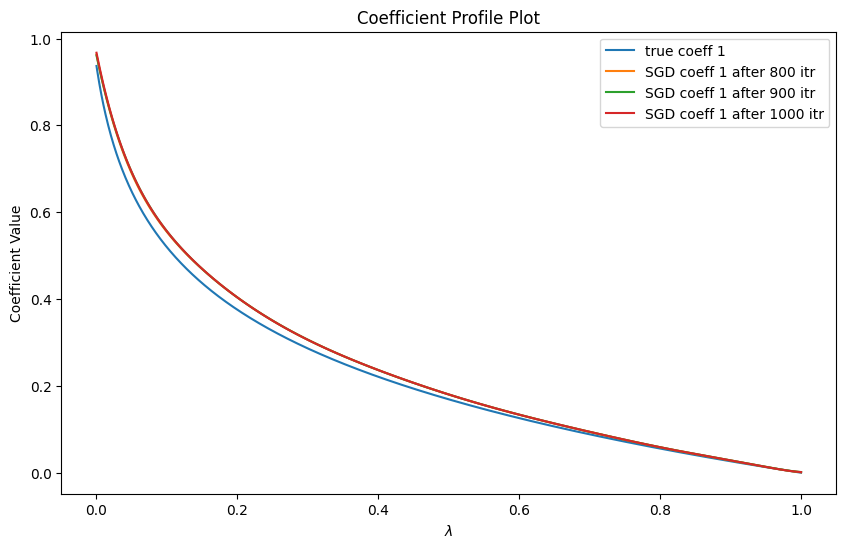

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, thetas[:,1], label=f'true coeff {1}')

for i in range(7, 10):
    plt.plot(lambdas, new_thetas_SGD_history[i][:,1], label=f'SGD coeff {1} after {(i+1)*100} itr')


# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Profile Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# intercepts
thetas_SGD_history[len(thetas_SGD_history)-1][:, 0]

array([-0.01217353, -0.01169915, -0.01123067, ..., -0.71340644,
       -0.7175921 , -0.7217976 ], dtype=float32)

In [ ]:
epoch = 1000
lr = 0.5**4

np.random.seed(8675309)
torch.manual_seed(8675309)
thetas_SGD_dim = []

for basis_dim in range(7, 2, -2):
    model = SGD.Basis_TF_SGD(input_dim_syn, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epoch):
        SGD.train_SGD(syn_data_loader, model, criterion, optimizer)

    thetas_SGD = []
    for lam in lambdas:
        thetas_SGD.append(model(lam).data.detach().numpy())
    thetas_SGD = np.array(thetas_SGD)
    thetas_SGD_dim.append(thetas_SGD)

Text(0, 0.5, 'Feature 2')

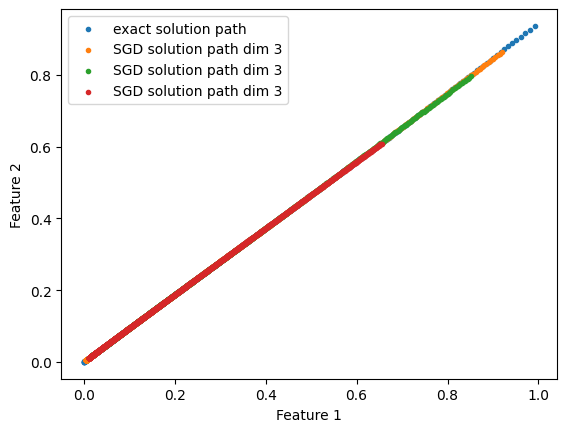

In [ ]:
# Create a scatter plot
plt.scatter(thetas[:, 0], thetas[:, 1], marker='.', label='exact solution path')

for i in range(len(thetas_SGD_dim)):
    plt.scatter(thetas_SGD_dim[i][:, 1], thetas_SGD_dim[i][:, 2], marker='.', label=f'SGD solution path dim {basis_dim}')

plt.legend()
# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')